In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, BoundaryNorm, LinearSegmentedColormap
import matplotlib.dates as mdates
from matplotlib import cm
import numpy as np
import os
import pandas as pd
from pyproj import Transformer
import scipy.stats
import xarray as xr

from windrose import WindroseAxes

# Load data and grab basic info

In [2]:
### Load data
dsn_hv = xr.open_zarr('/pl/active/WRFLES_GAD/wfp_3dpbl/real/3dpbl/nwf/2020_08/final.zarr')

dsn_m = xr.open_zarr('/pl/active/WRFLES_GAD/wfp_3dpbl/real/mynn-wrf4.3/nwf/2020_08/final.zarr')

In [3]:
### Grab basic data about files
## Times
times_n_hv = dsn_hv['time'].values

times_n_m = dsn_m['time'].values

## Coords
lons = dsn_hv['lon'].values
lats = dsn_hv['lat'].values
mean_lon = lons.mean()
mean_lat = lats.mean()

## Heights
heights = dsn_hv['height'].values

In [4]:
### Replace Time iterator data with timestamps
dsn_m = dsn_m.assign_coords({'Time':dsn_m['time'].data})
dsn_hv = dsn_hv.assign_coords({'Time':dsn_hv['time'].data})

In [5]:
### Calculate common time index for Aug 2020
## Prepare start and end index to trim timestamps to only Aug 2020
start_time = np.datetime64('2020-08-01')
end_time = np.datetime64('2020-09-01')

trimtime_n_hv_start = np.where(times_n_hv==start_time)[0][0]
trimtime_n_hv_end = np.where(times_n_hv==end_time)[0][0]
trimtime_n_m_start = np.where(times_n_m==start_time)[0][0]
trimtime_n_m_end = np.where(times_n_m==end_time)[0][0]

times = times_n_hv[trimtime_n_hv_start:trimtime_n_hv_end]

In [6]:
# ### Read turbine data
turbine_file_vw = 'windturbines_vw.txt'
turbine_df_vw = pd.read_csv(turbine_file_vw, delim_whitespace=True, usecols=[0,1], names=['Lat', 'Long'])

turbine_file_full = 'windturbines_full.txt'
turbine_df_full = pd.read_csv(turbine_file_full, delim_whitespace=True, usecols=[0,1], names=['Lat', 'Long'])

turbine_properties = '/projects/olry2348/WFIP2-WRF-3DPBL/runs/idealized/neutral/mynn-ztke/wind-turbine-1.tbl'
f = open(turbine_properties, "r")
lines = f.readlines()
hubheight = np.float(lines[1].split()[0])
rotor_diameter = np.float(lines[1].split()[1])
rotor_top = hubheight + rotor_diameter/2
rotor_bot = hubheight - rotor_diameter/2

print("Hub height", hubheight)
print("Rotor diameter", rotor_diameter)

Hub height 138.0
Rotor diameter 215.0


/tmp/ipykernel_161684/3324099769.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hubheight = np.float(lines[1].split()[0])
/tmp/ipykernel_161684/3324099769.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rotor_diameter = np.float(lines[1].split()[1])


In [7]:
### Pull key parameters out of turbine files
turb_lat_min_vw = turbine_df_vw['Lat'].min()
turb_lat_max_vw = turbine_df_vw['Lat'].max()
turb_long_min_vw = turbine_df_vw['Long'].min()
turb_long_max_vw = turbine_df_vw['Long'].max()

turb_lat_min_full = turbine_df_full['Lat'].min()
turb_lat_max_full = turbine_df_full['Lat'].max()
turb_long_min_full = turbine_df_full['Long'].min()
turb_long_max_full = turbine_df_full['Long'].max()

MAP_BOUNDS_turb_vw = [turb_long_min_vw-1, turb_long_max_vw+1, turb_lat_min_vw-1, turb_lat_max_vw+0.5]
MAP_BOUNDS_turb_full = [turb_long_min_full-0.5, turb_long_max_full+0.5, turb_lat_min_full-0.3, turb_lat_max_full+0.5]

In [8]:
### Prepare map elements
coastline_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '50m')
ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m')
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m')

states_50m = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', '50m')

In [9]:
### Process shapefiles for lease areas
## Load shapefiles
# df_lease = gpd.read_file('/home/orybchuk/shapefiles/BOEM_Lease_Areas_3_29_2021.shp')
df_lease = gpd.read_file('/projects/olry2348/shapefiles/BOEM_Lease_Areas_3_29_2021.shp')
crs = ccrs.PlateCarree()

## Merge (aka dissolve) geometries by lease area
df_lease_group = df_lease.dissolve(by='LeaseNo_Co')
df_lease_group = df_lease_group[~df_lease_group.index.str.contains('Virginia')]
df_lease_group = df_lease_group[~df_lease_group.index.str.contains('Avangrid Renewables')]
df_lease_group = df_lease_group[~df_lease_group.index.str.contains('Oregon')] 
df_lease_group = df_lease_group[~df_lease_group.index.str.contains('Narragansett')]

In [10]:
### Calculate centroids of all lease areas
## Calculate centroid in an equal area projection
lease_centroid_lat = df_lease_group.to_crs('+proj=cea').centroid.to_crs(df_lease_group.crs).y
lease_centroid_lon = df_lease_group.to_crs('+proj=cea').centroid.to_crs(df_lease_group.crs).x

df_lease_group['CentroidLat'] = lease_centroid_lat
df_lease_group['CentroidLon'] = lease_centroid_lon

## Calculate grid cell closest to centroid
lease_centroid_i = np.zeros_like(lease_centroid_lon)
lease_centroid_j = np.zeros_like(lease_centroid_lat)

for i in range(len(lease_centroid_lat)):
    centroid_dists = np.sqrt((lats - lease_centroid_lat[i])**2 \
                        + (lons - lease_centroid_lon[i])**2)

    this_j, this_i = np.unravel_index(np.argmin(centroid_dists, axis=None), centroid_dists.shape)
    
    lease_centroid_i[i], lease_centroid_j[i] = this_i, this_j
    
df_lease_group['CentroidI'] = lease_centroid_i.astype(int)
df_lease_group['CentroidJ'] = lease_centroid_j.astype(int)

# Calculate average wind speed and TKE profiles at the VW centroid

In [11]:
### Calculate average wind speed and TKE profiles at the VW centroid
## Identify VW centroid
vw_i = df_lease_group.loc['OCS-A 0501 - Vineyard Wind LLC', 'CentroidI']
vw_j = df_lease_group.loc['OCS-A 0501 - Vineyard Wind LLC', 'CentroidJ']

## Grab met variables
# Grab heat fluxes (for binning)
hfx_m = dsn_m['HFX'].isel(south_north=vw_j, west_east=vw_i, Time=slice(trimtime_n_m_start, trimtime_n_m_end))
hfx_hv = dsn_hv['HFX'].isel(south_north=vw_j, west_east=vw_i, Time=slice(trimtime_n_hv_start, trimtime_n_hv_end))

# Grab wind speeds
wspd_m_prof = dsn_m['WSPD'].isel(south_north=vw_j, west_east=vw_i, Time=slice(trimtime_n_m_start, trimtime_n_m_end))
wspd_hv_prof = dsn_hv['WSPD'].isel(south_north=vw_j, west_east=vw_i, Time=slice(trimtime_n_hv_start, trimtime_n_hv_end))

# Grab TKE
tke_m_prof = dsn_m['TKE'].isel(south_north=vw_j, west_east=vw_i, Time=slice(trimtime_n_m_start, trimtime_n_m_end))
tke_hv_prof = dsn_hv['TKE'].isel(south_north=vw_j, west_east=vw_i, Time=slice(trimtime_n_hv_start, trimtime_n_hv_end))

## Calculate stable/neutral/unstable times
# Set threshold
stable_thresh = -5   # W/m2
unstable_thresh = 5  # W/m2

# Grab time indices
time_s_m = hfx_m[hfx_m < stable_thresh]['Time'].values
time_n_m = hfx_m[(hfx_m > stable_thresh) & (hfx_m < unstable_thresh)]['Time'].values
time_u_m = hfx_m[hfx_m > unstable_thresh]['Time'].values

time_s_hv = hfx_hv[hfx_hv < stable_thresh]['Time'].values
time_n_hv = hfx_hv[(hfx_hv > stable_thresh) & (hfx_hv < unstable_thresh)]['Time'].values
time_u_hv = hfx_hv[hfx_hv > unstable_thresh]['Time'].values

## Calculate met conditions by stability
# Wind speed
wspd_s_m_mean = wspd_m_prof.sel(Time=time_s_m).mean('Time').values
wspd_n_m_mean = wspd_m_prof.sel(Time=time_n_m).mean('Time').values
wspd_u_m_mean = wspd_m_prof.sel(Time=time_u_m).mean('Time').values

wspd_s_hv_mean = wspd_hv_prof.sel(Time=time_s_hv).mean('Time').values
wspd_n_hv_mean = wspd_hv_prof.sel(Time=time_n_hv).mean('Time').values
wspd_u_hv_mean = wspd_hv_prof.sel(Time=time_u_hv).mean('Time').values

wspd_s_m_std = wspd_m_prof.sel(Time=time_s_m).std('Time').values
wspd_n_m_std = wspd_m_prof.sel(Time=time_n_m).std('Time').values
wspd_u_m_std = wspd_m_prof.sel(Time=time_u_m).std('Time').values

wspd_s_hv_std = wspd_hv_prof.sel(Time=time_s_hv).std('Time').values
wspd_n_hv_std = wspd_hv_prof.sel(Time=time_n_hv).std('Time').values
wspd_u_hv_std = wspd_hv_prof.sel(Time=time_u_hv).std('Time').values

# TKE
tke_s_m_mean = tke_m_prof.sel(Time=time_s_m).mean('Time').values
tke_n_m_mean = tke_m_prof.sel(Time=time_n_m).mean('Time').values
tke_u_m_mean = tke_m_prof.sel(Time=time_u_m).mean('Time').values

tke_s_hv_mean = tke_hv_prof.sel(Time=time_s_hv).mean('Time').values
tke_n_hv_mean = tke_hv_prof.sel(Time=time_n_hv).mean('Time').values
tke_u_hv_mean = tke_hv_prof.sel(Time=time_u_hv).mean('Time').values

In [12]:
print("Percent time in each stability at VW")
print(f"MYNN Stable:\t{time_s_m.shape[0]/len(hfx_m['Time'])*100:.0f}%")
print(f"MYNN Neutral:\t{time_n_m.shape[0]/len(hfx_m['Time'])*100:.0f}%")
print(f"MYNN Unstable:\t{time_u_m.shape[0]/len(hfx_m['Time'])*100:.0f}%")
print()
print(f"3DPBL Stable:\t{time_s_hv.shape[0]/len(hfx_hv['Time'])*100:.0f}%")
print(f"3DPBL Neutral:\t{time_n_hv.shape[0]/len(hfx_hv['Time'])*100:.0f}%")
print(f"3DPBL Unstable:\t{time_u_hv.shape[0]/len(hfx_hv['Time'])*100:.0f}%")

Percent time in each stability at VW
MYNN Stable:	35%
MYNN Neutral:	50%
MYNN Unstable:	15%

3DPBL Stable:	33%
3DPBL Neutral:	40%
3DPBL Unstable:	27%


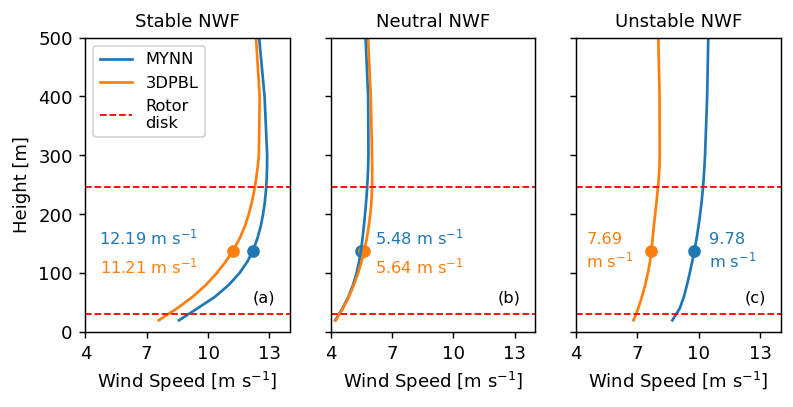

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(6.9,3), sharey=True, dpi=130)

## Plot
ax[0].plot(wspd_s_m_mean, heights, label='MYNN')
ax[0].plot(wspd_s_hv_mean, heights, label='3DPBL')
ax[1].plot(wspd_n_m_mean, heights, label='MYNN')
ax[1].plot(wspd_n_hv_mean, heights, label='3DPBL')
ax[2].plot(wspd_u_m_mean, heights, label='MYNN')
ax[2].plot(wspd_u_hv_mean, heights, label='3DPBL')

## Mark hubheight wind speed
wspd_s_m_hh = np.interp(hubheight, heights, wspd_s_m_mean)
wspd_n_m_hh = np.interp(hubheight, heights, wspd_n_m_mean)
wspd_u_m_hh = np.interp(hubheight, heights, wspd_u_m_mean)
wspd_s_hv_hh = np.interp(hubheight, heights, wspd_s_hv_mean)
wspd_n_hv_hh = np.interp(hubheight, heights, wspd_n_hv_mean)
wspd_u_hv_hh = np.interp(hubheight, heights, wspd_u_hv_mean)
   
ax[0].scatter(wspd_s_m_hh, hubheight, color='C0')
ax[0].scatter(wspd_s_hv_hh, hubheight, color='C1')
ax[1].scatter(wspd_n_m_hh, hubheight, color='C0')
ax[1].scatter(wspd_n_hv_hh, hubheight, color='C1')
ax[2].scatter(wspd_u_m_hh, hubheight, color='C0')
ax[2].scatter(wspd_u_hv_hh, hubheight, color='C1')
    
ax[0].text(0.55,
          0.3,
          np.round(wspd_s_m_hh,2).astype(str)+' m s$^{-1}$',
          fontsize=9,
          transform = ax[0].transAxes,
          horizontalalignment='right',
          color='C0')
ax[0].text(0.55,
          0.2,
          np.round(wspd_s_hv_hh,2).astype(str)+' m s$^{-1}$',
          fontsize=9,
          transform = ax[0].transAxes,
          horizontalalignment='right',
          color='C1')
ax[1].text(0.65,
          0.3,
          np.round(wspd_n_m_hh,2).astype(str)+' m s$^{-1}$',
          fontsize=9,
          transform = ax[1].transAxes,
          horizontalalignment='right',
          color='C0')
ax[1].text(0.65,
          0.2,
          np.round(wspd_n_hv_hh,2).astype(str)+' m s$^{-1}$',
          fontsize=9,
          transform = ax[1].transAxes,
          horizontalalignment='right',
          color='C1')
ax[2].text(0.65,
          0.22,
          np.round(wspd_u_m_hh,2).astype(str)+'\nm s$^{-1}$',
          fontsize=9,
          transform = ax[2].transAxes,
          horizontalalignment='left',
          color='C0')
ax[2].text(0.05,
          0.22,
          np.round(wspd_u_hv_hh,2).astype(str)+'\nm s$^{-1}$',
          fontsize=9,
          transform = ax[2].transAxes,
          horizontalalignment='left',
          color='C1')
    
## Turbines
for axs in ax.flatten():
    axs.axhline(rotor_top, color='r', lw=1, ls='--', label='Rotor\ndisk')
    axs.axhline(rotor_bot, color='r', lw=1, ls='--')

## Formatting
ax[0].set_ylim(0, 500)
for i in range(3):
    ax[i].set_xlim(4, 14)
    ax[i].set_xticks([4, 7, 10, 13])
    ax[i].set_xlabel("Wind Speed [m s$^{-1}$]", fontsize=10)

ax[0].set_ylabel("Height [m]", fontsize=10)
ax[0].set_title("Stable NWF", fontsize=10)
ax[1].set_title("Neutral NWF", fontsize=10)
ax[2].set_title("Unstable NWF", fontsize=10)

# plt.subplots_adjust(hspace=0.35)

## Subpanel labels
for axs, letter in zip(ax.flatten(), ['(a)', '(b)', '(c)']):
    axs.text(0.93,
          0.1,
          letter,
          fontsize=9,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='black')


# handles, labels = ax[0].get_legend_handles_labels()
# lgd = ax[0].legend(handles, labels, bbox_to_anchor=(0, -0.36, 3.5, .102), loc='upper left', fontsize=9, ncol=4, mode='expand',borderaxespad=0.)
ax[0].legend(fontsize=9)

# plt.savefig(f'../figs/vw_nwf.pdf', bbox_inches='tight')

    
plt.show()

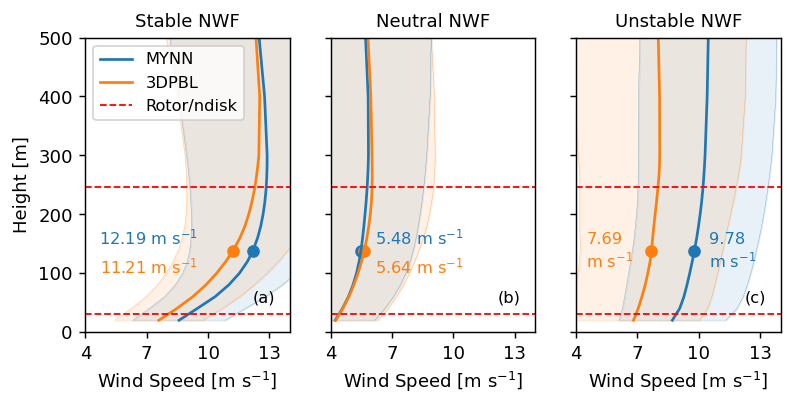

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(6.9,3), sharey=True, dpi=130)

## Plot
ax[0].plot(wspd_s_m_mean, heights, label='MYNN', color='C0')
ax[0].plot(wspd_s_m_mean+wspd_s_m_std, heights, color='C0', lw=0.1)
ax[0].plot(wspd_s_m_mean-wspd_s_m_std, heights, color='C0', lw=0.1)
ax[0].fill_betweenx(heights, wspd_s_m_mean-wspd_s_m_std, wspd_s_m_mean+wspd_s_m_std, color='C0', alpha=0.1)

ax[0].plot(wspd_s_hv_mean, heights, label='3DPBL', color='C1')
ax[0].plot(wspd_s_hv_mean+wspd_s_hv_std, heights, color='C1', lw=0.1)
ax[0].plot(wspd_s_hv_mean-wspd_s_hv_std, heights, color='C1', lw=0.1)
ax[0].fill_betweenx(heights, wspd_s_hv_mean-wspd_s_hv_std, wspd_s_hv_mean+wspd_s_hv_std, color='C1', alpha=0.1)

ax[1].plot(wspd_n_m_mean, heights, label='MYNN', color='C0')
ax[1].plot(wspd_n_m_mean+wspd_n_m_std, heights, color='C0', lw=0.1)
ax[1].plot(wspd_n_m_mean-wspd_n_m_std, heights, color='C0', lw=0.1)
ax[1].fill_betweenx(heights, wspd_n_m_mean-wspd_n_m_std, wspd_n_m_mean+wspd_n_m_std, color='C0', alpha=0.1)

ax[1].plot(wspd_n_hv_mean, heights, label='3DPBL', color='C1')
ax[1].plot(wspd_n_hv_mean+wspd_n_hv_std, heights, color='C1', lw=0.1)
ax[1].plot(wspd_n_hv_mean-wspd_n_hv_std, heights, color='C1', lw=0.1)
ax[1].fill_betweenx(heights, wspd_n_hv_mean-wspd_n_hv_std, wspd_n_hv_mean+wspd_n_hv_std, color='C1', alpha=0.1)

ax[2].plot(wspd_u_m_mean, heights, label='MYNN', color='C0')
ax[2].plot(wspd_u_m_mean+wspd_u_m_std, heights, color='C0', lw=0.1)
ax[2].plot(wspd_u_m_mean-wspd_u_m_std, heights, color='C0', lw=0.1)
ax[2].fill_betweenx(heights, wspd_u_m_mean-wspd_u_m_std, wspd_u_m_mean+wspd_u_m_std, color='C0', alpha=0.1)

ax[2].plot(wspd_u_hv_mean, heights, label='3DPBL', color='C1')
ax[2].plot(wspd_u_hv_mean+wspd_u_hv_std, heights, color='C1', lw=0.1)
ax[2].plot(wspd_u_hv_mean-wspd_u_hv_std, heights, color='C1', lw=0.1)
ax[2].fill_betweenx(heights, wspd_u_hv_mean-wspd_u_hv_std, wspd_u_hv_mean+wspd_u_hv_std, color='C1', alpha=0.1)

## Mark hubheight wind speed
wspd_s_m_hh = np.interp(hubheight, heights, wspd_s_m_mean)
wspd_n_m_hh = np.interp(hubheight, heights, wspd_n_m_mean)
wspd_u_m_hh = np.interp(hubheight, heights, wspd_u_m_mean)
wspd_s_hv_hh = np.interp(hubheight, heights, wspd_s_hv_mean)
wspd_n_hv_hh = np.interp(hubheight, heights, wspd_n_hv_mean)
wspd_u_hv_hh = np.interp(hubheight, heights, wspd_u_hv_mean)
   
ax[0].scatter(wspd_s_m_hh, hubheight, color='C0')
ax[0].scatter(wspd_s_hv_hh, hubheight, color='C1')
ax[1].scatter(wspd_n_m_hh, hubheight, color='C0')
ax[1].scatter(wspd_n_hv_hh, hubheight, color='C1')
ax[2].scatter(wspd_u_m_hh, hubheight, color='C0')
ax[2].scatter(wspd_u_hv_hh, hubheight, color='C1')
    
ax[0].text(0.55,
          0.3,
          np.round(wspd_s_m_hh,2).astype(str)+' m s$^{-1}$',
          fontsize=9,
          transform = ax[0].transAxes,
          horizontalalignment='right',
          color='C0')
ax[0].text(0.55,
          0.2,
          np.round(wspd_s_hv_hh,2).astype(str)+' m s$^{-1}$',
          fontsize=9,
          transform = ax[0].transAxes,
          horizontalalignment='right',
          color='C1')
ax[1].text(0.65,
          0.3,
          np.round(wspd_n_m_hh,2).astype(str)+' m s$^{-1}$',
          fontsize=9,
          transform = ax[1].transAxes,
          horizontalalignment='right',
          color='C0')
ax[1].text(0.65,
          0.2,
          np.round(wspd_n_hv_hh,2).astype(str)+' m s$^{-1}$',
          fontsize=9,
          transform = ax[1].transAxes,
          horizontalalignment='right',
          color='C1')
ax[2].text(0.65,
          0.22,
          np.round(wspd_u_m_hh,2).astype(str)+'\nm s$^{-1}$',
          fontsize=9,
          transform = ax[2].transAxes,
          horizontalalignment='left',
          color='C0')
ax[2].text(0.05,
          0.22,
          np.round(wspd_u_hv_hh,2).astype(str)+'\nm s$^{-1}$',
          fontsize=9,
          transform = ax[2].transAxes,
          horizontalalignment='left',
          color='C1')
    
## Turbines
for axs in ax.flatten():
    axs.axhline(rotor_top, color='r', lw=1, ls='--', label='Rotor/ndisk')
    axs.axhline(rotor_bot, color='r', lw=1, ls='--')

## Formatting
ax[0].set_ylim(0, 500)
for i in range(3):
    ax[i].set_xlim(4, 14)
    ax[i].set_xticks([4, 7, 10, 13])
    ax[i].set_xlabel("Wind Speed [m s$^{-1}$]", fontsize=10)

ax[0].set_ylabel("Height [m]", fontsize=10)
ax[0].set_title("Stable NWF", fontsize=10)
ax[1].set_title("Neutral NWF", fontsize=10)
ax[2].set_title("Unstable NWF", fontsize=10)

# plt.subplots_adjust(hspace=0.35)

## Subpanel labels
for axs, letter in zip(ax.flatten(), ['(a)', '(b)', '(c)']):
    axs.text(0.93,
          0.1,
          letter,
          fontsize=9,
          transform = axs.transAxes,
          horizontalalignment='right',
            color='black')


# handles, labels = ax[0].get_legend_handles_labels()
# lgd = ax[0].legend(handles, labels, bbox_to_anchor=(0, -0.36, 3.5, .102), loc='upper left', fontsize=9, ncol=4, mode='expand',borderaxespad=0.)
ax[0].legend(fontsize=9)

# plt.savefig(f'../figs/vw_nwf_std.pdf', bbox_inches='tight')

    
plt.show()

# Comapre wind roses at VW for each stability

In [15]:
### Calculate wind directions by stability
## Grab hub-height wind directions and wind speeds at VW centroid
kloc = 6
wdir_hh_m = dsn_m['WDIR'].isel(south_north=vw_j, west_east=vw_i, bottom_top=kloc, Time=slice(trimtime_n_m_start, trimtime_n_m_end))
wdir_hh_hv = dsn_hv['WDIR'].isel(south_north=vw_j, west_east=vw_i, bottom_top=kloc, Time=slice(trimtime_n_hv_start, trimtime_n_hv_end))

wspd_hh_m = dsn_m['WSPD'].isel(south_north=vw_j, west_east=vw_i, bottom_top=kloc, Time=slice(trimtime_n_m_start, trimtime_n_m_end))
wspd_hh_hv = dsn_hv['WSPD'].isel(south_north=vw_j, west_east=vw_i, bottom_top=kloc, Time=slice(trimtime_n_hv_start, trimtime_n_hv_end))

## Filter by stability
# Wind direction
wdir_hh_s_m = wdir_hh_m.sel(Time=time_s_m).values
wdir_hh_n_m = wdir_hh_m.sel(Time=time_n_m).values
wdir_hh_u_m = wdir_hh_m.sel(Time=time_u_m).values

wdir_hh_s_hv = wdir_hh_hv.sel(Time=time_s_hv).values
wdir_hh_n_hv = wdir_hh_hv.sel(Time=time_n_hv).values
wdir_hh_u_hv = wdir_hh_hv.sel(Time=time_u_hv).values

# Wind speed
wspd_hh_s_m = wspd_hh_m.sel(Time=time_s_m).values
wspd_hh_n_m = wspd_hh_m.sel(Time=time_n_m).values
wspd_hh_u_m = wspd_hh_m.sel(Time=time_u_m).values

wspd_hh_s_hv = wspd_hh_hv.sel(Time=time_s_hv).values
wspd_hh_n_hv = wspd_hh_hv.sel(Time=time_n_hv).values
wspd_hh_u_hv = wspd_hh_hv.sel(Time=time_u_hv).values

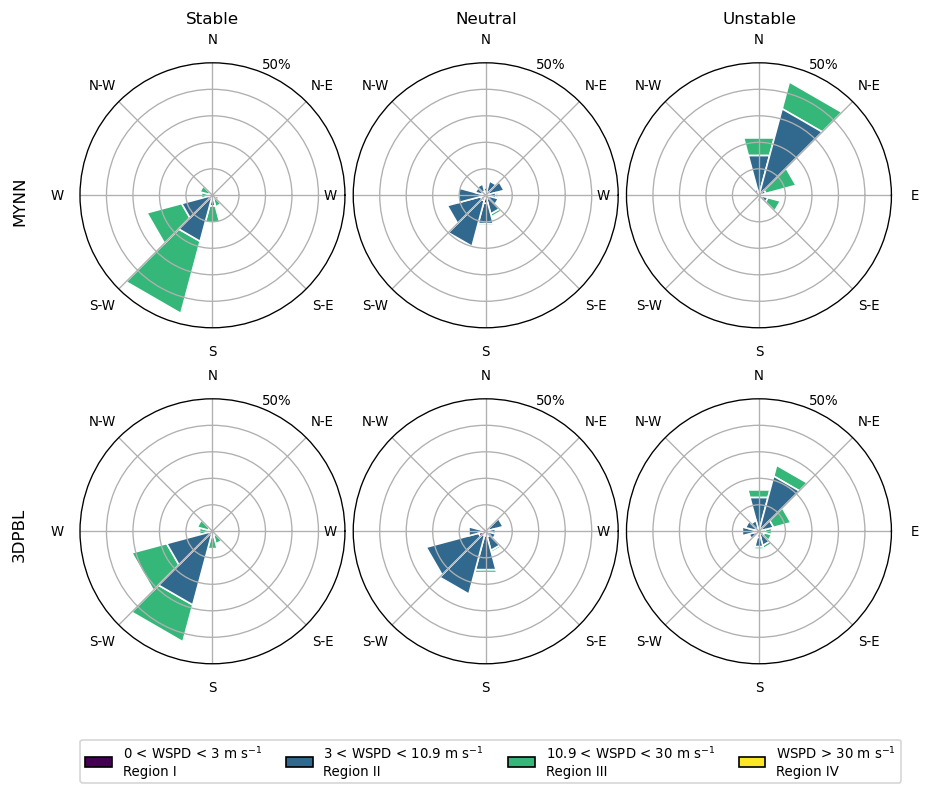

In [16]:
### Plot wind roses
## Set up figure and subplots
##     https://stackoverflow.com/questions/42733194/subplot-of-windrose-in-matplotlib
fig = plt.figure(figsize=[6.9,7], dpi=120)
rect1 = [0,0,0.32,0.32] 
ax1 = WindroseAxes(fig, rect1)
fig.add_axes(ax1)

rect2 = [0,0.40,0.32,0.32] 
ax2 = WindroseAxes(fig, rect2)
fig.add_axes(ax2)

rect3 = [0.33,0,0.32,0.32] 
ax3 = WindroseAxes(fig, rect3)
fig.add_axes(ax3)

rect4 = [0.33,0.40,0.32,0.32] 
ax4 = WindroseAxes(fig, rect4)
fig.add_axes(ax4)

rect5 = [0.66,0,0.32,0.32] 
ax5 = WindroseAxes(fig, rect5)
fig.add_axes(ax5)

rect6 = [0.66,0.40,0.32,0.32] 
ax6 = WindroseAxes(fig, rect6)
fig.add_axes(ax6)

## Font sizes
cb_fs = 18
lb_fs = 18
tk_fs = 14
bx_fs = 20

## Plot roses (using Mike and Nicola's code)
bins = [0, 3, 10.9, 30]
ax2.bar(wdir_hh_s_m, wspd_hh_s_m, cmap=cm.viridis, normed=True, 
           nsector=12, bins=bins, opening=1, edgecolor='white') # the main plot function
ax1.bar(wdir_hh_s_hv, wspd_hh_s_hv, cmap=cm.viridis, normed=True, 
           nsector=12, bins=bins, opening=1, edgecolor='white')

ax4.bar(wdir_hh_n_m, wspd_hh_n_m, cmap=cm.viridis, normed=True, 
           nsector=12, bins=bins, opening=1, edgecolor='white') # the main plot function
ax3.bar(wdir_hh_n_hv, wspd_hh_n_hv, cmap=cm.viridis, normed=True, 
           nsector=12, bins=bins, opening=1, edgecolor='white')

ax6.bar(wdir_hh_u_m, wspd_hh_u_m, cmap=cm.viridis, normed=True, 
           nsector=12, bins=bins, opening=1, edgecolor='white') # the main plot function
ax5.bar(wdir_hh_u_hv, wspd_hh_u_hv, cmap=cm.viridis, normed=True, 
           nsector=12, bins=bins, opening=1, edgecolor='white')

## Set radial tick labels
ax2.tick_params(labelsize=8)
ax2.set_rlabel_position(340) #degrees
ax2.set_rmax(50) # max percentage (external circle)
ax2.set_rticks(np.arange(10,50,10)) # internal circles
# ax2.set_yticklabels(['', '', '', '', '', '35%'], fontsize=8)

for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.text(0.8,
              0.98,
              '50%',
              fontsize=8,
              transform = ax.transAxes,
              horizontalalignment='right')

for ax in [ax1, ax3, ax4, ax5, ax6]:
    ax.tick_params(labelsize=8)
    ax.set_rmax(50) # max percentage (external circle)
    ax.set_rticks(np.arange(10,50,10)) # internal circles
#     ax.set_yticklabels(['', '', '', '', '', ''], fontsize=8)


## Legend
leg = ax1.legend(bbox_to_anchor=(0., -0.45, 3.1, .102),
                    loc='lower left',
                    ncol=4,
                    mode='expand',
                    borderaxespad=0.,
                    fontsize=8)
leg.get_texts()[0].set_text('0 < WSPD < 3 m s$^{-1}$\nRegion I')
leg.get_texts()[1].set_text('3 < WSPD < 10.9 m s$^{-1}$\nRegion II')
leg.get_texts()[2].set_text('10.9 < WSPD < 30 m s$^{-1}$\nRegion III')
leg.get_texts()[3].set_text('WSPD > 30 m s$^{-1}$\nRegion IV')

## Label areas
ax2.text(0.60,
          1.15,
          'Stable',
          fontsize=10,
          transform = ax2.transAxes,
          horizontalalignment='right')
ax4.text(0.62,
          1.15,
          'Neutral',
          fontsize=10,
          transform = ax4.transAxes,
          horizontalalignment='right')
ax6.text(0.64,
          1.15,
          'Unstable',
          fontsize=10,
          transform = ax6.transAxes,
          horizontalalignment='right')

ax2.text(-0.2,
          0.4,
          'MYNN',
          fontsize=10,
          transform = ax2.transAxes,
          horizontalalignment='right',
          rotation=90)

ax1.text(-0.2,
          0.4,
          '3DPBL',
          fontsize=10,
          transform = ax1.transAxes,
          horizontalalignment='right',
          rotation=90)

# plt.savefig("../figs/vw_windrose.pdf", bbox_inches='tight')

plt.show()

# Compare wind speed distributions by stability

In [17]:
### Calculate histogram by stability
wind_bins = np.arange(0, 32, 1)

wspd_hist_stable_m_np = np.histogram(
                            wspd_hh_s_m,
                            wind_bins)
wspd_hist_stable_m_hist = scipy.stats.rv_histogram(wspd_hist_stable_m_np)

wspd_hist_neutral_m_np = np.histogram(
                            wspd_hh_n_m,
                            wind_bins)
wspd_hist_neutral_m_hist = scipy.stats.rv_histogram(wspd_hist_neutral_m_np)

wspd_hist_unstable_m_np = np.histogram(
                            wspd_hh_u_m,
                            wind_bins)
wspd_hist_unstable_m_hist = scipy.stats.rv_histogram(wspd_hist_unstable_m_np)


wspd_hist_stable_hv_np = np.histogram(
                            wspd_hh_s_hv,
                            wind_bins)
wspd_hist_stable_hv_hist = scipy.stats.rv_histogram(wspd_hist_stable_hv_np)

wspd_hist_neutral_hv_np = np.histogram(
                            wspd_hh_n_hv,
                            wind_bins)
wspd_hist_neutral_hv_hist = scipy.stats.rv_histogram(wspd_hist_neutral_hv_np)

wspd_hist_unstable_hv_np = np.histogram(
                            wspd_hh_u_hv,
                            wind_bins)
wspd_hist_unstable_hv_hist = scipy.stats.rv_histogram(wspd_hist_unstable_hv_np)

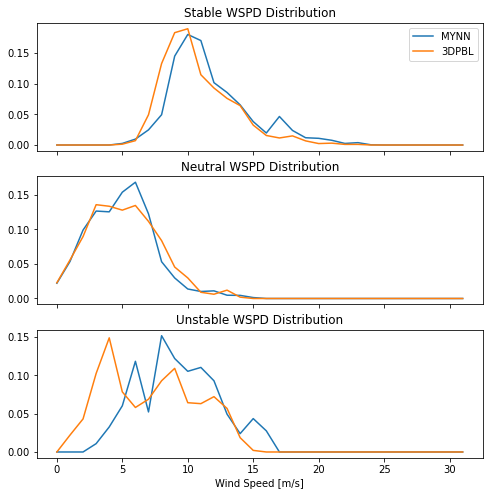

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(8,8), sharex=True)

ax[0].plot(wind_bins, 
        wspd_hist_stable_m_hist.pdf(wind_bins),
        color='C0', 
        label='MYNN')
ax[0].plot(wind_bins, 
        wspd_hist_stable_hv_hist.pdf(wind_bins),
        color='C1', 
        label='3DPBL')

ax[1].plot(wind_bins, 
        wspd_hist_neutral_m_hist.pdf(wind_bins),
        color='C0', 
        label='MYNN')
ax[1].plot(wind_bins, 
        wspd_hist_neutral_hv_hist.pdf(wind_bins),
        color='C1', 
        label='3DPBL')

ax[2].plot(wind_bins, 
        wspd_hist_unstable_m_hist.pdf(wind_bins),
        color='C0', 
        label='MYNN')
ax[2].plot(wind_bins, 
        wspd_hist_unstable_hv_hist.pdf(wind_bins),
        color='C1', 
        label='3DPBL')

ax[0].set_title("Stable WSPD Distribution")
ax[1].set_title("Neutral WSPD Distribution")
ax[2].set_title("Unstable WSPD Distribution")
ax[2].set_xlabel("Wind Speed [m/s]")
ax[0].legend()

plt.show()